# Chocolate Rating Analysis

# Web scraping data to then process, clean, etc. in the notebook.

In [1]:
# import warnings
# warnings.filterwarnings('ignore')

# from requests import get
# from bs4 import BeautifulSoup
# import pandas as pd
# from selenium import webdriver
# import chromedriver_autoinstaller
# def create_driver(headless=True):
#     driver = chromedriver_autoinstaller.install(cwd=True)
#     chrome_options = webdriver.ChromeOptions()     
#     if headless:
#         chrome_options.add_argument("--headless")
#     driver = webdriver.Chrome(driver, 
#                              chrome_options = chrome_options)
#     return driver
# driver = create_driver()

In [2]:
# driver.get("http://flavorsofcacao.com/chocolate_database.html")

In [3]:
# div_id = "spryregion1"

# html = driver.page_source
# soup = BeautifulSoup(html)
# div = soup.find('div', {'id':div_id})
# # div

# table = div.find('table')
# table


In [4]:
# pd.read_html(str(table))[0]

In [5]:
# df.to_csv('../../../data/chocolate.csv', index=False)

# Importing Necessary Python Libraries 

In [880]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import plot_confusion_matrix, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from collections import Counter

all_data = pd.read_csv('../../../data/chocolate.csv')
all_data.head()

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63%,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70%,"4- B,S,C,L","vegetal, nutty",3.50


# Data Cleaning 

### Replacing column spaces with underscores and lower casing column names for simplicity when calling them. 

In [881]:
#breaking away from original dataset and creating a copy to maintain the original structure as "all_data"
df = all_data.copy()

In [882]:
#removing parenthesis and spaces from columns 
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.lower()

#removing percent signs from row cocoa_percent
df = df.replace("%", "", regex=True)
# turning percentage of cocoa into a float
df["cocoa_percent"] = df.cocoa_percent.astype(float)

df.head()

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63.0,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,"4- B,S,C,L","vegetal, nutty",3.50


# Exploratory Data Analysis: 
Determining the goals for the features in terms of which to compare to the target variable and the take aways for each feaure

## Looking into the relationships of chocolate characteristics and company location. 

### Evaluating the most memorable characteristics 

In [883]:
# over 2300 combinations of flavors 
df.most_memorable_characteristics.value_counts().sum()

2362

In [884]:
df.most_memorable_characteristics.value_counts()

spicy, cocoa                   4
creamy, nutty, cocoa           4
cherry, rich choco             3
sandy, sweet, cocoa            3
sweet, vanilla, cocoa          3
                              ..
basic cocoa, short length      1
banana, fall spices, earthy    1
floral, grain, deep cocoa      1
creamy, sweet, fudgey          1
sandy, mild citrus, sweet      1
Name: most_memorable_characteristics, Length: 2320, dtype: int64

### Breaking up flavors individually and determining the weighted average (weighted_occurance * rating) for the top 25 flavors

In [885]:
###? delete the few below?

In [886]:
#word list returns words from the dataframe that have been split
# word_list = [word.strip().replace(',', '').replace('"', '') for word in " ".join(df.most_memorable_characteristics).split()]

# word_counts = np.unique(word_list, return_counts=True)
# word_c = np.array([word_counts[0], word_counts[1]])
# word_df = pd.DataFrame(word_c.T, columns=['word', 'count'])
# word_df.sort_values(by='count', ascending=False)

### Checking to see how many times each flavor appears

In [887]:
count = 0
for c in df.most_memorable_characteristics.values:
    if 'sweet' in [x.strip().replace(',', '').replace('"', '') for x in c.split(', ')]:
        count += 1
count

248

In [888]:
word_count_list = Counter(word_list).most_common(25)
word_count_list

[('cocoa', 356),
 ('sweet', 287),
 ('nutty', 260),
 ('fruit', 236),
 ('roasty', 210),
 ('mild', 208),
 ('sour', 185),
 ('earthy', 185),
 ('creamy', 183),
 ('intense', 166),
 ('sandy', 161),
 ('fatty', 157),
 ('floral', 150),
 ('spicy', 144),
 ('rich', 141),
 ('bitter', 120),
 ('off', 104),
 ('vanilla', 101),
 ('molasses', 90),
 ('coffee', 87),
 ('woody', 85),
 ('spice', 79),
 ('sticky', 78),
 ('berry', 72),
 ('tart', 70)]

In [889]:
x = [count_list[0] for count_list in word_count_list]
y = [count_list[1] for count_list in word_count_list]

In [890]:
cleaned_word_list = []

#grabbing an arry of charcteristics, splitting (sepparating them by columns) and cleaning them
for char in df['most_memorable_characteristics'].values:
    l = char.split(', ')
    clean_list = [word.replace(',', '').replace('"', '').strip() for word in l] 
    cleaned_word_list.append(clean_list)
     
#assigning the clean word list to the memorable char column
df['memorable_characteristics_list'] = cleaned_word_list

In [891]:
# grabbing the shape of the full dataframe
num_rows = df.shape[0]

# creating an empty dictionary to fill with the chocolate characteristics and their weighted averages 
weighted_chars = {}

for word in x:
    #the df[df is returning the values associated with the list comprehension - lambda rather than a boolean
    word_df = df[df['memorable_characteristics_list'].apply(lambda lst: word in lst)]
    avg_rating = word_df['rating'].mean()
    weight = len(word_df) / num_rows
    weighted_chars[word] = avg_rating * weight 

In [892]:
#turning the dictionary into a dataframe
sorted_weighted_chars_df = pd.DataFrame(list(zip(weighted_chars.keys(), weighted_chars.values())), columns=['chocolate_char', 'weighted_rating']).sort_values(by='weighted_rating',ascending=False)

#ensuring that the chocolate characteristics are sorted according to their weighted averages
sorted_weighted_chars_df.head(3)

,chocolate_char,weighted_rating
2,nutty,0.338696
1,sweet,0.319750
0,cocoa,0.304509


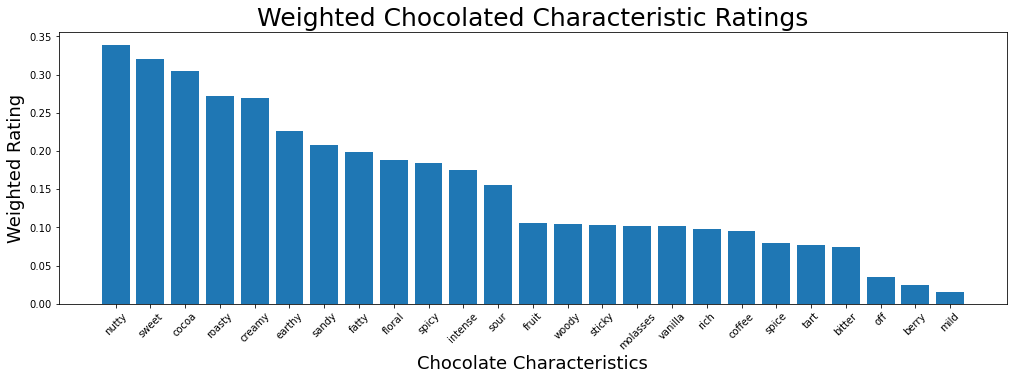

In [893]:
# Plotting the most memorable characteristics

import matplotlib.pyplot as plt

x = sorted_weighted_chars_df['chocolate_char']

y = sorted_weighted_chars_df['weighted_rating']

fig, ax = plt.subplots(figsize=(17,5))
plt.xticks(rotation = 45)
plt.title('Weighted Chocolated Characteristic Ratings', fontsize=25)
plt.xlabel('Chocolate Characteristics', fontsize=18)
plt.ylabel('Weighted Rating', fontsize=18)

plt.bar(x,y)
plt.show()

* The chocolate characteristics appears to have visual groups in relation to the weighted ratings. It might be helpful to group them before modeling

* It also appears that certain chocolate bars that were sold the most contain characteristics that were not highly rated. 

## Evaluating the Company Location

### Inspecting the company location's weighted average in relation to rating

In [894]:
# Average rating of each country. ex: 'Puerto Rico': 2.625
average_ratings_company_location = df.groupby('company_location')['rating'].mean().sort_values().to_dict()


In [895]:
# Percentage of Country appearances. ex: 'U.S.A.': 0.42929720575783237
company_location_counts = df['company_location'].value_counts(normalize=True).to_dict()


### creating a dictionary of the country that the chocolate bars were sold in as keys and their weighted ratings as the values 

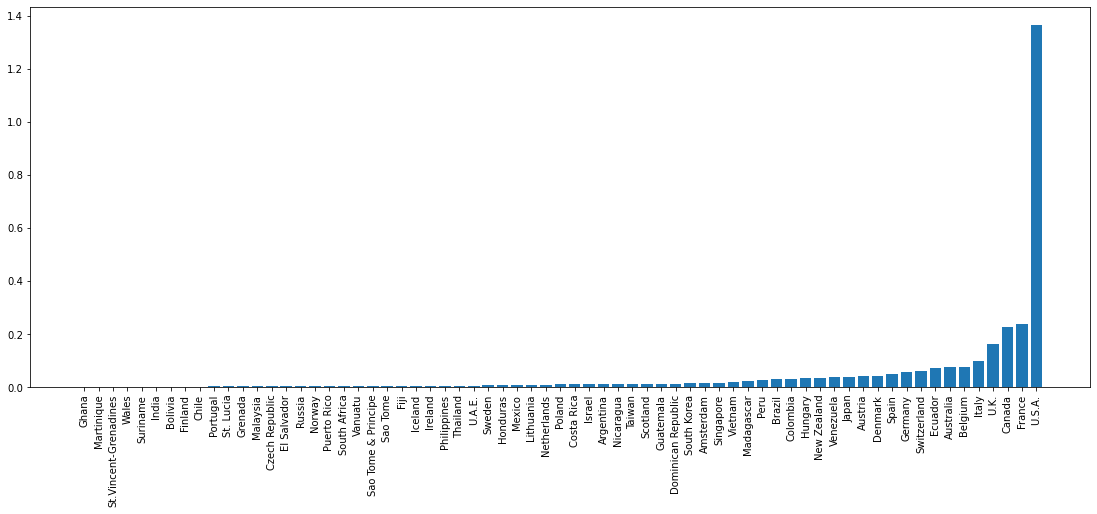

In [896]:
#creating a weighted average number of appearances * rating
companies_loc = df.company_location.unique()


#Inspecting the weighting average of the appearance of countries and the rating 

#ex: country appearance percentage * country average rating 
weighted_rating = []
for company in companies_loc:
    count = company_location_counts[company]
    rating = average_ratings_company_location[company]
    weighted_rating.append(count * rating)
    
sorted_comp_rating_vals = sorted(list(zip(weighted_rating, companies_loc)))
x = [val[1] for val in sorted_comp_rating_vals]
y = [val[0] for val in sorted_comp_rating_vals]

# Creating a vizualization for the relationships weighted ratings compared with countries 
plt.figure(figsize=(19,7))
plt.bar(x, y)
plt.xticks(rotation=90);


### Placing the countries into groups of low, medium, and high ratings and breaking them based on their indexes and renaming them as 1, 2, and 3. 

In [897]:
#Matching the country weighted ratings with each country.
#company_loc -> unique country non-repeated 
group_df = pd.DataFrame(list(zip(companies_loc, weighted_rating)), columns=['country', 'weighted_rating'])
group_df.head()

,country,weighted_rating
0,U.S.A.,1.364204
1,France,0.239522
2,Fiji,0.005504
3,Vanuatu,0.004657
4,Ecuador,0.074619


### using q-cut with a value of 3

In [898]:
group_df['weighted_company_bins'] = pd.qcut(group_df['weighted_rating'], 
                                            labels=['low', 'middle', 'high'], q=3)


In [899]:
group_df.head(2)

,country,weighted_rating,weighted_company_bins
0,U.S.A.,1.364204,high
1,France,0.239522,high


In [900]:
weighted_company_bins = group_df.set_index('country')['weighted_company_bins'].to_dict()

In [901]:
df['company_loc_bins'] = df['company_location'].map(weighted_company_bins)

### changing the high, middle, low into the values 1,2,and 3 to avoid later OneHotEncoding

In [902]:
company_bin = []
for c in df['company_loc_bins'].values:     # -> ex: 'high', 'high', 'high', ..., 'high', 'high', 'high'
    if c == 'low':
        company_bin.append(1)
    elif c == 'middle':
        company_bin.append(2)
    else:
        company_bin.append(3)

#ensuring that 
df['company_loc_bins'] = company_bin
df['company_loc_bins'].value_counts()

3    2119
2     182
1      61
Name: company_loc_bins, dtype: int64

### binning the company location into groups of A, B, and C.

In [903]:
df

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"[cocoa, vegetal, savory]",3
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25,"[rich cocoa, fatty, bready]",3
3,797,A. Morin,France,2012,Peru,Peru,63.0,"4- B,S,C,L","fruity, melon, roasty",3.75,"[fruity, melon, roasty]",3
4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,"4- B,S,C,L","vegetal, nutty",3.50,"[vegetal, nutty]",3
...,...,...,...,...,...,...,...,...,...,...,...,...
2357,1205,Zotter,Austria,2014,Blend,Raw,80.0,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75,"[waxy, cloying, vegetal]",3
2358,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75.0,"3- B,S,C","strong nutty, marshmallow",3.75,"[strong nutty, marshmallow]",3
2359,2170,Zotter,Austria,2018,Belize,Maya Mtn,72.0,"3- B,S,C","muted, roasty, accessible",3.50,"[muted, roasty, accessible]",3
2360,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70.0,"3- B,S,C","fatty, mild nuts, mild fruit",3.25,"[fatty, mild nuts, mild fruit]",3


In [904]:
first_bin = x[:47]
df['comp_location_indexing_bin'] = 1

bin_a_index = df[df.company_location.isin(first_bin)].index
df.at[bin_a_index, 'comp_location_indexing_bin'] = 'a'

In [905]:
idx = x.index('Italy') + 1
second_bin = x[47:idx]

bin_b_index = df[df.company_location.isin(second_bin)].index
df.at[bin_b_index, 'comp_location_indexing_bin'] = 'b'

In [906]:
idx2 = x.index('U.K.') 
third_bin = x[idx2:]

bin_c_index = df[df.company_location.isin(third_bin)].index
df.at[bin_c_index, 'comp_location_indexing_bin'] = 'c'

In [907]:
x[idx2:]

['U.K.', 'Canada', 'France', 'U.S.A.']

In [908]:
df.value_counts('comp_location_indexing_bin')

comp_location_indexing_bin
c    1477
b     610
a     275
dtype: int64

## Determining weighted ratings of country bean origin 

**thought process:**

* group specific_bean_origin_or_bar_name with country_location 
    - compare with rating and group according to high/low.
    
* group country_of_bean_origin with country_location
    - compare with rating and group according to high/low. 

<AxesSubplot:>

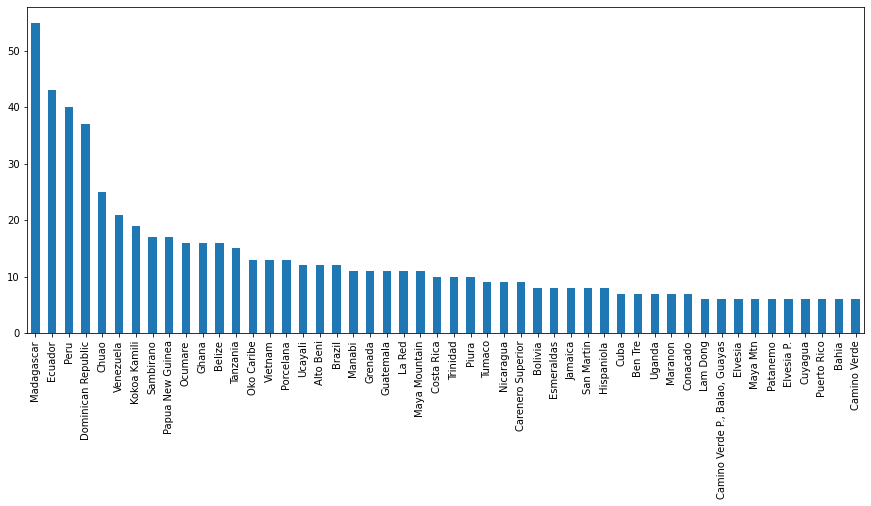

In [909]:
df['specific_bean_origin_or_bar_name'].value_counts()[:50].plot(kind='bar', figsize=(15,6))

* Seeing that Madagascar - the Dominican Republic indicates that they are prioritizing making the chocolate beans, but not creating the chocolate bars. It would be intersting to group them with where the chocolate bars are made and compare them with rating.

In [910]:
df[df.company_location == 'U.S.A.'].country_of_bean_origin.value_counts()

Dominican Republic    140
Peru                  100
Ecuador                83
Venezuela              82
Madagascar             68
Blend                  54
Bolivia                48
Belize                 47
Tanzania               43
Nicaragua              31
Guatemala              29
U.S.A.                 28
Costa Rica             27
Brazil                 25
Ghana                  22
Vietnam                22
Trinidad               18
Colombia               17
Mexico                 16
Jamaica                14
Papua New Guinea       13
Honduras               13
India                  12
Haiti                  11
Uganda                 11
Fiji                    8
Indonesia               5
Sierra Leone            4
Philippines             4
Puerto Rico             3
Liberia                 3
Ivory Coast             3
Nigeria                 2
Congo                   2
Grenada                 2
Solomon Islands         2
Panama                  1
Cameroon                1
Name: countr

In [911]:
df[df.company_location == 'U.S.A.'].specific_bean_origin_or_bar_name.value_counts()

Dominican Republic                25
Ecuador                           22
Madagascar                        20
Peru                              17
Kokoa Kamili                      15
                                  ..
Hispaniola, batch 170104           1
Oko Caribe, batch 1 SRB            1
Ben Tre, Mekond Delta, 2018 H.     1
Oko Caribe, batch 0719             1
Ben Tre, 2018 Harvest              1
Name: specific_bean_origin_or_bar_name, Length: 678, dtype: int64

<AxesSubplot:>

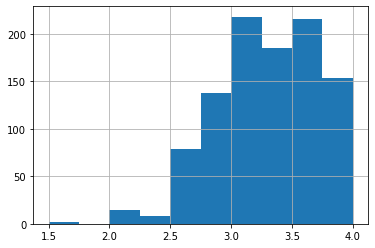

In [912]:
df[df.company_location == 'U.S.A.'].rating.hist()

* it is apparent that U.S.A has a high variance in terms of ratings and would need to be broken into groups of low and high ratings. 

**CURRENTLY HAVE:**

- Weighted country location rating (count * rating)

Bean origin 

Spacifin Bean origin 

In [913]:
df.head(2)

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins,comp_location_indexing_bin
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3,c
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"[cocoa, vegetal, savory]",3,c


### Grouping the bean origin and specific bean origin with the company location's rating 

In [914]:
# Average rating of each country bean origin. ex: 'Puerto Rico': 2.625
average_ratings_bean_origin = df.groupby('country_of_bean_origin')['rating'].mean().sort_values().to_dict()


In [915]:
#Returning the country appearances as a normalized value (percentage):
# ex: 'U.S.A.': 0.42929720575783237

origin_location_counts = df['country_of_bean_origin'].value_counts(normalize=True).to_dict()


### creating a dictionary of the bean origin as keys and their weighted ratings as the values 

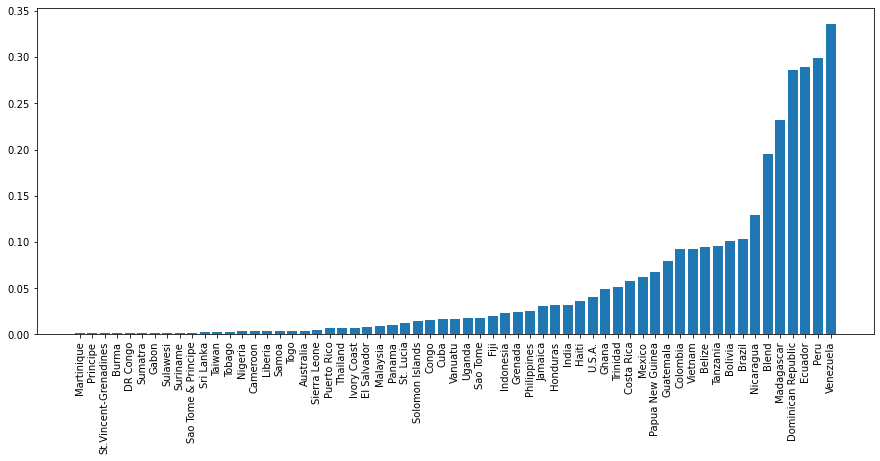

In [916]:
#Inspecting the weighting average ratings of the country of bean origins

#Returning the unique countries from the original dataframe   -> #ex:'Madagascar', 'Dominican Republic', 'Tanzania', 'Peru', 'Bolivia'
origin_loc = df.country_of_bean_origin.unique()  

#creating an list to place the name and weighted average ratings into 
weighted_bean_rating = []

#looping through a mathmetical computation that finds the weighted rating 
for place in origin_loc:
    country_count = origin_location_counts[place]
    country_rating = average_ratings_bean_origin[place]
    #taking the maen rating and * by the country appearance percentage 
    weighted_bean_rating.append(country_count * country_rating)
    
# sorting the values and placing them into a dictionary of {rating,location}
sort_weight_origin_rating = sorted(list(zip(weighted_bean_rating, origin_loc)))

# creating a for loop that takes the weighted rating and sets them equal to x
x = [w[1] for w in sort_weight_origin_rating]
# creating a for loop that takes the weighted rating and sets them equal to y
y = [w[0] for w in sort_weight_origin_rating]

# Creating a vizualization for the relationships weighted ratings compared with countries 
plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.xticks(rotation=90);

In [917]:
df.head(1)

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins,comp_location_indexing_bin
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3,c


In [918]:
#Matching the country weighted ratings with each country.
#company_loc -> unique country non-repeated 
group_df_bean = pd.DataFrame(list(zip(origin_loc, weighted_bean_rating)), columns=['country', 'weighted_rating'])
group_df_bean.head()

,country,weighted_rating
0,Madagascar,0.232218
1,Dominican Republic,0.286452
2,Tanzania,0.095364
3,Peru,0.299217
4,Bolivia,0.101185


In [919]:

group_df_bean['weighted_company_bins'] = pd.qcut(group_df['weighted_rating'], 
                                            labels=['low', 'middle', 'high'], q=3)

#creating a dictionary to map it to the MAIN dataframe 'df'
weighted_company_bins = group_df.set_index('country')['weighted_company_bins'].to_dict()

df['bean_origin_bins'] = df['company_location'].map(weighted_company_bins)

### changing the high, middle, low into the values 1,2,and 3 to avoid later OneHotEncoding

In [920]:
company_bin = []
for c in df['bean_origin_bins'].values:     # -> ex: 'high', 'high', 'high', ..., 'high', 'high', 'high'
    if c == 'low':
        company_bin.append(1)
    elif c == 'middle':
        company_bin.append(2)
    else:
        company_bin.append(3)

#ensuring that 
df['bean_origin_bins'] = company_bin
df['bean_origin_bins'].value_counts()


3    2119
2     182
1      61
Name: bean_origin_bins, dtype: int64

In [921]:
df.head(2)

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins,comp_location_indexing_bin,bean_origin_bins
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3,c,3
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"[cocoa, vegetal, savory]",3,c,3


## Determining weighted ratings of specific bean origin 

In [922]:
# Average rating of each country. ex: 'Puerto Rico': 2.625
average_ratings_specific_bean_origin = df.groupby('specific_bean_origin_or_bar_name')['rating'].mean().sort_values().to_dict()


In [923]:
# Percentage of Country appearances. ex: 'U.S.A.': 0.42929720575783237
specific_origin_location_counts = df['specific_bean_origin_or_bar_name'].value_counts(normalize=True).to_dict()


In [924]:
df.specific_bean_origin_or_bar_name.value_counts()

Madagascar                                      55
Ecuador                                         43
Peru                                            40
Dominican Republic                              37
Chuao                                           25
                                                ..
Huallabamba, 2015                                1
Abstract S. w/ Jamaica nibs,batch abs60323.0     1
Sumatra                                          1
Cocibolca                                        1
Fortissima                                       1
Name: specific_bean_origin_or_bar_name, Length: 1475, dtype: int64

### creating a dictionary of the specific bean origin as keys and their weighted ratings as the values 

In [925]:
#Inspecting the weighting average ratings of the country of bean origins

#Returning the unique countries from the original dataframe   -> #ex:'Madagascar', 'Dominican Republic', 'Tanzania', 'Peru', 'Bolivia'
# specific_loc = df.specific_bean_origin_or_bar_name.unique()  

#creating an list to place the name and weighted average ratings into 
weighted_bean_rating = []

#looping through a mathmetical computation that finds the weighted rating 
for place in most_common_bean_loc:
    country_count = specific_origin_location_counts[place]
    country_rating = average_ratings_specific_bean_origin[place]
    #taking the maen rating and * by the country appearance percentage 
    weighted_bean_rating.append(country_count * country_rating)
    
# sorting the values and placing them into a dictionary of {rating,location}
sort_weight_specificOrigin_rating = sorted(list(zip(weighted_bean_rating, specific_loc)))

# creating a for loop that takes the weighted rating and sets them equal to x
x = [w[1] for w in sort_weight_origin_rating]
# creating a for loop that takes the weighted rating and sets them equal to y
y = [w[0] for w in sort_weight_origin_rating]

In [926]:
#Matching the country weighted ratings with each country.
#company_loc -> unique country non-repeated 
group_df_specific_origin = pd.DataFrame(list(zip(origin_loc, weighted_bean_rating)), columns=['country', 'weighted_rating'])
group_df_specific_origin.head()

,country,weighted_rating
0,Madagascar,0.075042
1,Dominican Republic,0.049428
2,Tanzania,0.056943
3,Peru,0.048264
4,Bolivia,0.034293


### setting specific origin to values of low, middle, and high

In [927]:

group_df_specific_origin['weighted_specific_bins'] = pd.qcut(group_df['weighted_rating'], 
                                            labels=['low', 'middle', 'high'], q=3)

#creating a dictionary to map it to the MAIN dataframe 'df'
weighted_company_bins = group_df_specific_origin.set_index('country')['weighted_specific_bins'].to_dict()

df['weighted_specific_origin_bins'] = df['specific_bean_origin_or_bar_name'].map(weighted_company_bins)

### changing the high, middle, low into the values 1,2,and 3 to avoid later OneHotEncoding


In [928]:

company_bin = []
for c in df['weighted_specific_origin_bins'].values:     # -> ex: 'high', 'high', 'high', ..., 'high', 'high', 'high'
    if c == 'low':
        company_bin.append(1)
    elif c == 'middle':
        company_bin.append(2)
    else:
        company_bin.append(3)


df['weighted_specific_origin_bins'] = company_bin
df['weighted_specific_origin_bins'].value_counts()


3    2187
2      92
1      83
Name: weighted_specific_origin_bins, dtype: int64

In [929]:
df

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins,comp_location_indexing_bin,bean_origin_bins,weighted_specific_origin_bins
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3,c,3,3
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"[cocoa, vegetal, savory]",3,c,3,3
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25,"[rich cocoa, fatty, bready]",3,c,3,3
3,797,A. Morin,France,2012,Peru,Peru,63.0,"4- B,S,C,L","fruity, melon, roasty",3.75,"[fruity, melon, roasty]",3,c,3,1
4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,"4- B,S,C,L","vegetal, nutty",3.50,"[vegetal, nutty]",3,c,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,1205,Zotter,Austria,2014,Blend,Raw,80.0,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75,"[waxy, cloying, vegetal]",3,b,3,3
2358,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75.0,"3- B,S,C","strong nutty, marshmallow",3.75,"[strong nutty, marshmallow]",3,b,3,3
2359,2170,Zotter,Austria,2018,Belize,Maya Mtn,72.0,"3- B,S,C","muted, roasty, accessible",3.50,"[muted, roasty, accessible]",3,b,3,3
2360,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70.0,"3- B,S,C","fatty, mild nuts, mild fruit",3.25,"[fatty, mild nuts, mild fruit]",3,b,3,3


In [930]:
df.company_bins.value_counts()

AttributeError: 'DataFrame' object has no attribute 'company_bins'

In [931]:
# Returning only the weighted ratings from the U.S.A. that were high

df['USA_high_bean_origin'] = df.country_of_bean_origin[(df.company_location == 'U.S.A.') & (df.company_bins == 'high')]

# df['USA_low'] = df.country_of_bean_origin[(df.company_location == 'U.S.A.') & (df.company_bins == 'high')]
# print(random)

AttributeError: 'DataFrame' object has no attribute 'company_bins'

In [932]:
df.head()

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins,comp_location_indexing_bin,bean_origin_bins,weighted_specific_origin_bins
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3,c,3,3
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"[cocoa, vegetal, savory]",3,c,3,3
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25,"[rich cocoa, fatty, bready]",3,c,3,3
3,797,A. Morin,France,2012,Peru,Peru,63.0,"4- B,S,C,L","fruity, melon, roasty",3.75,"[fruity, melon, roasty]",3,c,3,1
4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,"4- B,S,C,L","vegetal, nutty",3.50,"[vegetal, nutty]",3,c,3,3


## Determining how impactful the chocolate bar ingredients are to the target when paired with company location

### removing the unnecissary information leading up to the ingredient names

In [933]:
# retreiving rows from the third index and on - leaving out rows with empty values
df['ingredient_list'] = [np.nan if l is np.nan else l[3:] for l in df['ingredients']]

In [934]:
df['ingredient_list'].value_counts()

B,S,C          903
B,S            661
B,S,C,L        273
B,S,C,V,L      184
B,S,C,V        139
B,S*            31
B,S*,C,Sa       20
B,S*,C          12
B,S,L            8
B,S*,C,V         7
,S,C,V,Sa        6
B,S,C,Sa         5
B,S,V,L          5
B                5
,S,C,V,L,Sa      4
B,S*,V,L         3
B,S,V            3
B,S*,C,L         2
B,C              1
B,S,C,L,Sa       1
B,S*,Sa          1
Name: ingredient_list, dtype: int64

### leaving out occurances below 8 


In [935]:

most_common = (df['ingredient_list'].value_counts()).iloc[:9].index


df = df[df['ingredient_list'].isin(most_common)]


### Inspecting the value (occurance count) and leaving out those with a low number of occurances

In [936]:
#ensuring that values below 8 were removed
df.ingredient_list.value_counts()

B,S,C        903
B,S          661
B,S,C,L      273
B,S,C,V,L    184
B,S,C,V      139
B,S*          31
B,S*,C,Sa     20
B,S*,C        12
B,S,L          8
Name: ingredient_list, dtype: int64

In [937]:
df

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins,comp_location_indexing_bin,bean_origin_bins,weighted_specific_origin_bins,ingredient_list
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3,c,3,3,"B,S,C"
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"[cocoa, vegetal, savory]",3,c,3,3,"B,S,C"
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25,"[rich cocoa, fatty, bready]",3,c,3,3,"B,S,C"
3,797,A. Morin,France,2012,Peru,Peru,63.0,"4- B,S,C,L","fruity, melon, roasty",3.75,"[fruity, melon, roasty]",3,c,3,1,"B,S,C,L"
4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,"4- B,S,C,L","vegetal, nutty",3.50,"[vegetal, nutty]",3,c,3,3,"B,S,C,L"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,1205,Zotter,Austria,2014,Blend,Raw,80.0,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75,"[waxy, cloying, vegetal]",3,b,3,3,"B,S*,C,Sa"
2358,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75.0,"3- B,S,C","strong nutty, marshmallow",3.75,"[strong nutty, marshmallow]",3,b,3,3,"B,S,C"
2359,2170,Zotter,Austria,2018,Belize,Maya Mtn,72.0,"3- B,S,C","muted, roasty, accessible",3.50,"[muted, roasty, accessible]",3,b,3,3,"B,S,C"
2360,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70.0,"3- B,S,C","fatty, mild nuts, mild fruit",3.25,"[fatty, mild nuts, mild fruit]",3,b,3,3,"B,S,C"


--------------------------

# Preprocessing

## Clarifying important predictor values (x) for the target value (y).

In [121]:
# dropping the target (y) values from x and specific origin
features = df.drop(['rating','specific_bean_origin_or_bar_name', 'ingredients', 'review_date', 'ref'], axis =1)
X = features
y = df.rating


### Splitting the data into three subsets of training and validation data for the future models.
    Two train test splits create three subsets of the original dataset which allows for the training data to not be bled into the test data - this reduced model's bias towards the pre-existing testing data, thus assuring maximum performance on future test sets which the model has never been exposed. 

In [122]:
#performing train test split for test set (subsets 1/3)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.15, random_state=42)


#performing a train test split for train and validation set (subsets - 3/3)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.15, random_state=42) 

In [49]:
#checking to ensure the shape of the columns and rows are still the same for the X and y values after the train test split.
X_tr.shape, y_tr.shape

((1896, 10), (1896,))

### Replacing any existing missing values  

In [50]:
#ingredients have 88 rows that have no imputs.
X_val.isna().sum()

company_manufacturer              0
company_location                  0
country_of_bean_origin            0
cocoa_percent                     0
most_memorable_characteristics    0
memorable_characteristics_list    0
company_bins                      0
comp_location_bin                 0
company_bin                       0
ingredient_list                   0
dtype: int64

In [51]:
# the empty value replacement will be done using the most frequent fill strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X.columns)

X_val_imputed = pd.DataFrame(imputer.fit_transform(X_val),columns = X.columns)

TypeError: unhashable type: 'list'

In [ ]:
#ensuring that the missing values from ingredients are now filled in with the most frequent occuring value

X_val_imputed.isna().sum()

### Separating groups into numeric and catagorical data types 

In [ ]:
#taking a look at the groups data types to ensure that they are separated correctly
X_train.info()

In [ ]:
# X_train_numeric 
# X_train_cat

# X_val_numerica

## Preprocessing: